# Análise e Modelagem do Preço - petróleo bruto - Brent💲

#### Neste notebook, vamos abordar o processo de análise e modelagem da série temporal do petróleo brent, desde a análise exploratória até a modelagem usando diferentes técnicas.

### Carregando os Dados

In [1]:
# Importando as bibliotecas necessárias:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

# Carregando os dados da base de dados contida no site do ipea.
# Isso nos daria uma boa combinação de detalhes e quantidade, cobrindo uma variedade de eventos econômicos e políticos.
brent_data = pd.read_excel(r"C:\Users\alefc\OneDrive\Documentos\FIAP\Fase04\TechChall\Preço por barril do petróleo bruto Brent.xlsx", parse_dates=[0]) # Altere o caminho para onde está o seu arquivo ⚠️

# Verificaremos a estrutura dos dados e faremos uma análise preliminar:
brent_data.head()

c:\Users\alefc\anaconda3\lib\site-packages\statsforecast\core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


,data,preco_petroleo_bruto,unique_id
0,2023-12-29,77.69,1
1,2023-12-28,79.04,1
2,2023-12-27,80.97,1
3,2023-12-26,80.23,1
4,2023-12-22,80.23,1


In [2]:
# Verificando o conteúdo da base (tipo de dado, quantidade entre outros):
brent_data.info()

'''
Os dados da ipeadata contêm as seguintes colunas:

Data: A data da cotação do preço. (Diária).
Preço - petróleo bruto - Brent (FOB): O preço do barril do petróleo Brent em dólares (US$).
unique_id: Um identificador único para cada registro.✔️
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10917 entries, 0 to 10916
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   data                  10917 non-null  datetime64[ns]
 1   preco_petroleo_bruto  10917 non-null  float64       
 2   unique_id             10917 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 256.0 KB


'\nOs dados da ipeadata contêm as seguintes colunas:\n\nData: A data da cotação do preço. (Diária).\nPreço - petróleo bruto - Brent (FOB): O preço do barril do petróleo Brent em dólares (US$).\nunique_id: Um identificador único para cada registro.✔️\n'

#### Os dados foram disponibilizados limpos, desta forma podemos avançar para a análise exploratória. Primeiro, vamos visualizar a série temporal para entender melhor as tendências e padrões nos dados.

### Análise Exploratória dos Dados 🤓

#### Com os dados limpos, podemos avançar para a análise exploratória. Primeiro, vamos visualizar a série temporal do valor de fechamento ("preco_petroleo_bruto") para entender melhor as tendências e padrões nos dados.

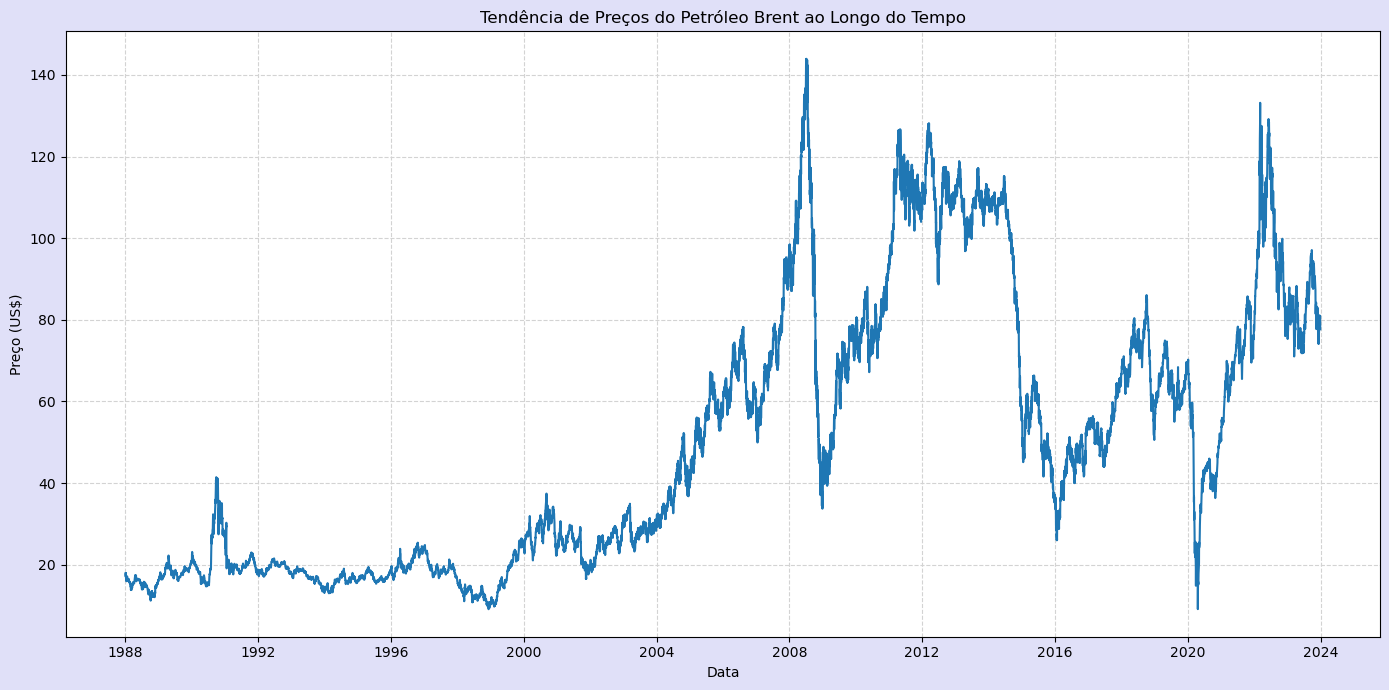

In [3]:
# Começamos examinando a série temporal para identificar tendências, sazonalidades e outros padrões visuais:

plt.figure(figsize=(14,7)).set_facecolor('#E0E0F8')
plt.plot(brent_data['data'], brent_data['preco_petroleo_bruto'])
plt.title('Tendência de Preços do Petróleo Brent ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço (US$)')
plt.grid(True, color='lightgray', linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

#### A partir do gráfico, observamos que a série temporal possui tendências claras, mas a sazonalidade não é imediatamente evidente. Também notamos alguns períodos de alta volatilidade.
#### Vamos fazer uma análise decomposição da série temporal, para isso vamos usar a função seasonal_decompose da biblioteca statsmodels, pois é uma excelente ferramenta para decompor uma série temporal em seus componentes principais: tendência, sazonalidade e resíduo.

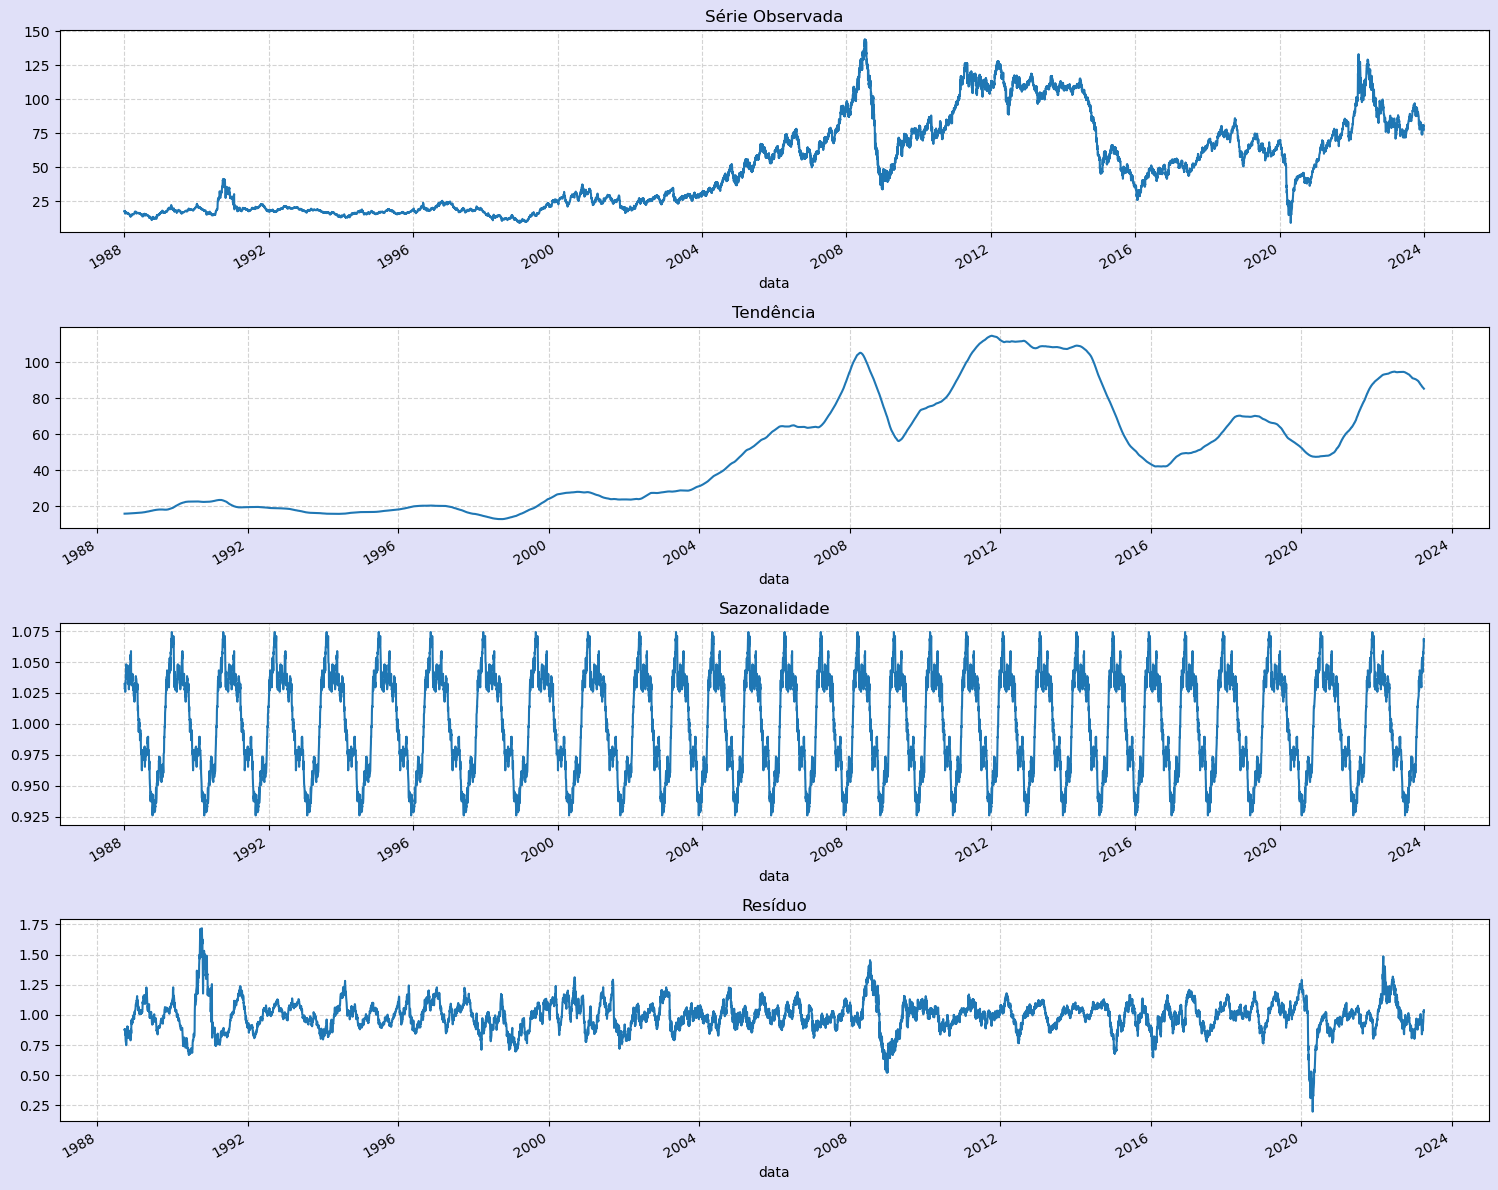

In [4]:
# Configurar a data como índice:
brent_data_new = brent_data.set_index('data')

# Decompor a série
result = seasonal_decompose(brent_data_new['preco_petroleo_bruto'], model='multiplicative', period=365)

# Visualizar os componentes decompostos
fig = plt.figure(figsize=(15, 12))
fig.set_facecolor('#E0E0F8')

# Série Observada
plt.subplot(4, 1, 1)
result.observed.plot(title='Série Observada', ax=plt.gca())
plt.grid(True, color='lightgray', linestyle='--')

# Tendência
plt.subplot(4, 1, 2)
result.trend.plot(title='Tendência', ax=plt.gca())
plt.grid(True, color='lightgray', linestyle='--')

# Sazonalidade
plt.subplot(4, 1, 3)
result.seasonal.plot(title='Sazonalidade', ax=plt.gca())
plt.grid(True, color='lightgray', linestyle='--')

# Resíduo
plt.subplot(4, 1, 4)
result.resid.plot(title='Resíduo', ax=plt.gca())
plt.grid(True, color='lightgray', linestyle='--')

plt.tight_layout()
plt.show()


#### Tendência: A tendência observada nos preços do petróleo Brent mostra um movimento geral ascendente ao longo do período analisado. Este aumento progressivo pode ser atribuído a uma série de fatores econômicos globais, incluindo inflação, demanda crescente por energia e eventos geopolíticos que afetam a oferta de petróleo. Nota-se também que existem períodos de estabilização e até declínio nos preços, o que pode refletir momentos de crise econômica internacional, avanços em fontes alternativas de energia ou mudanças significativas na política de produção de países exportadores de petróleo.

#### Sazonalidade:A componente sazonal do preço do petróleo Brent revela picos e vales regulares, indicando padrões repetitivos que podem estar ligados aos ciclos de negócios e variações estacionais na demanda de energia. Por exemplo, é comum observar um aumento na demanda de petróleo durante os meses de inverno, devido à maior necessidade de aquecimento, e uma queda durante o verão. Eventos sazonais, como períodos de férias onde há aumento no tráfego de veículos, também podem influenciar esses padrões sazonais, por exemplo.

#### Resíduo: O resíduo representa o que não foi explicado pela tendência ou sazonalidade e, idealmente, deve se assemelhar a um ruído branco, ou seja, uma série de valores aleatórios distribuídos uniformemente em torno de zero. No entanto, observamos que há estruturas aparentes nos resíduos, sugerindo que fatores adicionais não capturados pela tendência e sazonalidade podem estar influenciando os preços do petróleo Brent. Isso pode incluir choques econômicos inesperados, alterações políticas, ou outras variáveis de mercado que não são cíclicas nem seguem uma tendência de longo prazo. A presença de padrões nos resíduos indica a necessidade de explorar modelos mais complexos ou de investigar mais a fundo os fatores exógenos que podem estar em jogo. ⚠️

## As tensões no Oriente Médio ⚔️

#### Os eventos geopolíticos foram um dos principais fatores que contribuíram para a variação do preço do petróleo Brent durante esse período. As tensões no Oriente Médio, em particular, tiveram um impacto significativo nos preços. Em 2008, a invasão do Iraque pela coalizão liderada pelos Estados Unidos levou a um aumento no preço do petróleo, que atingiu um pico de US$ 140 por barril em julho daquele ano. Em 2011, a Primavera Árabe também levou a um aumento no preço do petróleo, à medida que os conflitos na região interromperam a produção e o transporte de petróleo.

#### As sanções internacionais também podem afetar os preços do petróleo. Por exemplo, as sanções impostas ao Irã em 2012 levaram a um aumento no preço do petróleo, à medida que o país reduziu a produção de petróleo em resposta às sanções.

#### Além dos eventos geopolíticos, os fatores econômicos também podem afetar os preços do petróleo. Por exemplo, um crescimento econômico global forte pode aumentar a demanda por petróleo, levando a um aumento nos preços. Um crescimento econômico global fraco pode reduzir a demanda por petróleo, levando a uma queda nos preços.

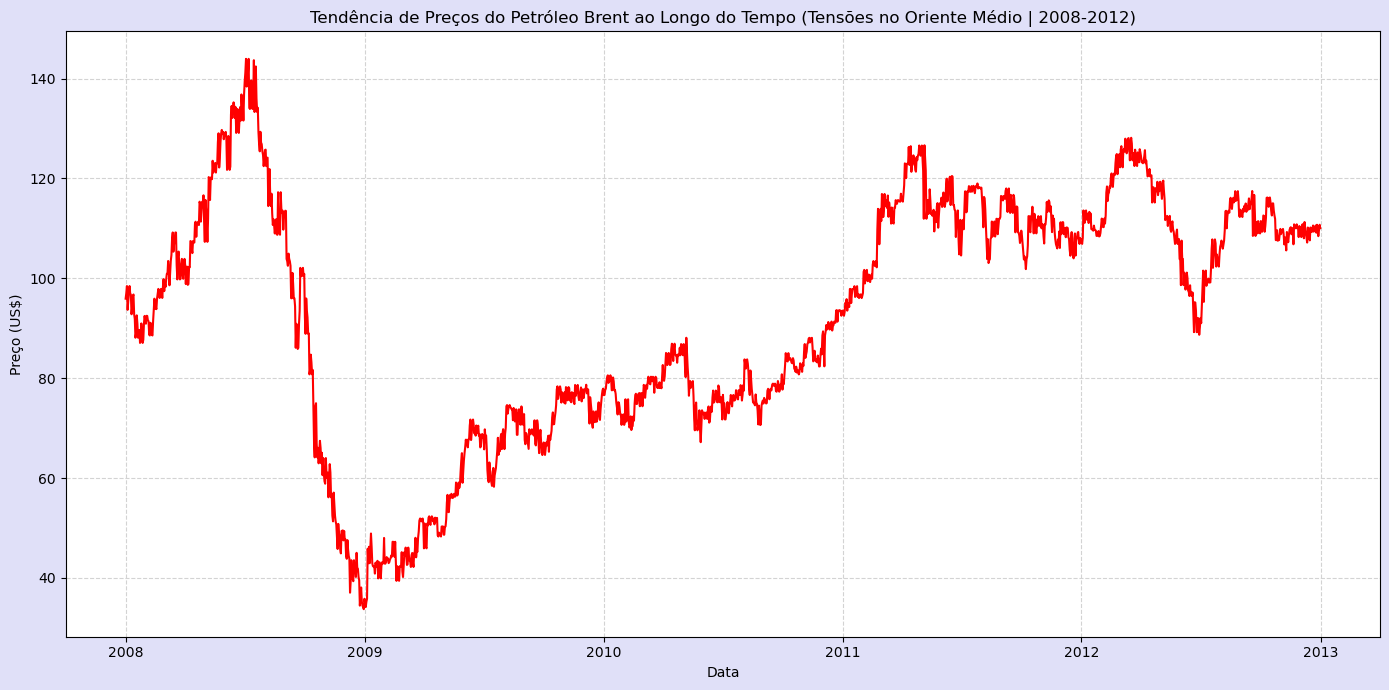

In [5]:
# Filtrando os dados do período de tensões no oriente médio (2008-2012):
war_period = brent_data_new['2008-01-01':'2012-12-31']

# Plot dos dados para o período pandêmico:
plt.figure(figsize=(14,7)).set_facecolor('#E0E0F8')
plt.plot(war_period.index, war_period['preco_petroleo_bruto'], color='r')
plt.title('Tendência de Preços do Petróleo Brent ao Longo do Tempo (Tensões no Oriente Médio | 2008-2012)')
plt.xlabel('Data')
plt.ylabel('Preço (US$)')
plt.grid(True, color='lightgray', linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

## Pandemia 😷

#### O preço do petróleo Brent apresentou uma variação significativa entre dezembro de 2019 e fevereiro de 2022. Em dezembro de 2019, o preço do barril de petróleo Brent estava em torno de US$ 62. Em fevereiro de 2020, o preço do barril caiu para US$ 27, o menor valor desde 2004. Essa queda foi causada pela pandemia de COVID-19, que levou a uma redução da demanda global por petróleo.

#### A partir de março de 2020, o preço do petróleo Brent começou a se recuperar, atingindo um pico de US$ 81,72 em agosto de 2022. Essa recuperação foi impulsionada pela recuperação da demanda global por petróleo, bem como pelas tensões geopolíticas no Oriente Médio.

#### No período pós-pandemia, o preço do petróleo Brent apresentou uma trajetória de alta, com um pico em agosto de 2022. Esse pico foi causado, principalmente, pelas tensões geopolíticas no Oriente Médio, que levaram a uma redução da oferta global de petróleo.

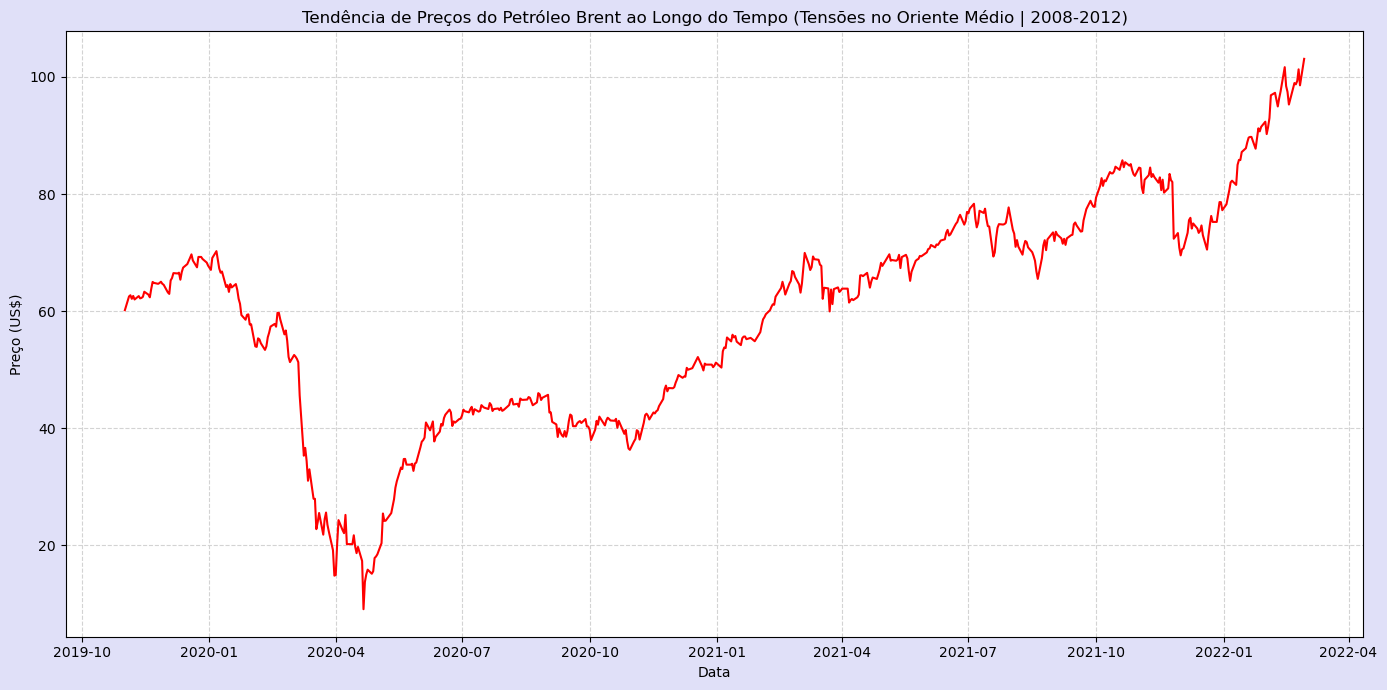

In [6]:
# Filtrando os dados do período pandêmico:
pandemic_period = brent_data_new['2019-11-01':'2022-02-28']

# Plot dos dados para o período pandêmico:
plt.figure(figsize=(14,7)).set_facecolor('#E0E0F8')
plt.plot(pandemic_period.index, pandemic_period['preco_petroleo_bruto'], color='r')
plt.title('Tendência de Preços do Petróleo Brent ao Longo do Tempo (Tensões no Oriente Médio | 2008-2012)')
plt.xlabel('Data')
plt.ylabel('Preço (US$)')
plt.grid(True, color='lightgray', linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

#### Em Agosto de 2022, os Estados Unidos e seus aliados impuseram sanções à Rússia em resposta à invasão da Ucrânia.

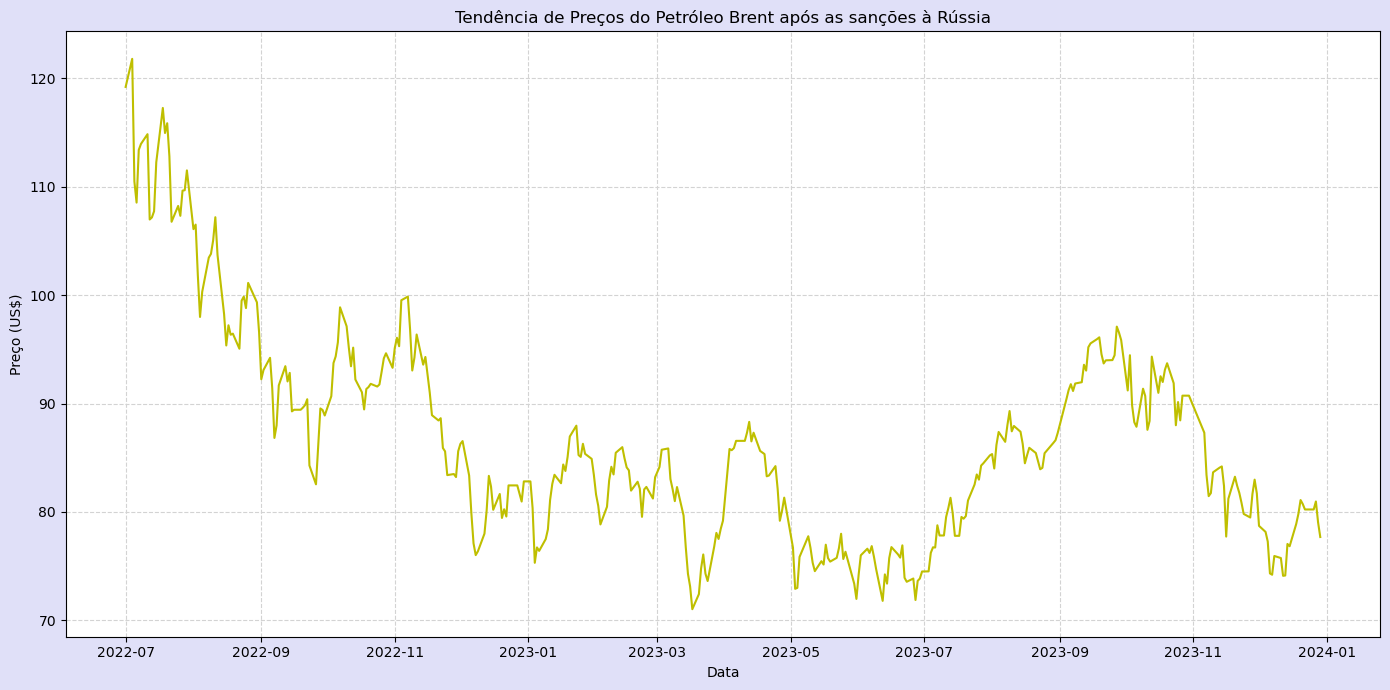

In [7]:
# Filtrando os dados do período de sanções à Rússia:
pandemic_period = brent_data_new['2022-07-01':'2023-12-31']

# Plot dos dados para o período pandêmico:
plt.figure(figsize=(14,7)).set_facecolor('#E0E0F8')
plt.plot(pandemic_period.index, pandemic_period['preco_petroleo_bruto'], color='y')
plt.title('Tendência de Preços do Petróleo Brent após as sanções à Rússia')	
plt.xlabel('Data')
plt.ylabel('Preço (US$)')
plt.grid(True, color='lightgray', linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

## Construção e Treinamento do Modelo 🤖

#### Podemos começar a pensar em modelar a série temporal. Existem várias técnicas para modelagem de séries temporais, como ARIMA, SARIMAX, Prophet, entre outras.
#### No entanto, antes de escolher um modelo, vamos fazer uma divisão entre treino e teste. Isso nos permitirá treinar o modelo nos dados de treino e avaliar seu desempenho nos dados de teste.
#### Uma abordagem comum para séries temporais é fazer uma divisão temporal, onde usamos uma certa porcentagem dos dados mais antigos para treino e uma porcentagem dos dados mais recentes para teste.

In [8]:
# Vou dividir os dados em 80% para treino e 20% para teste. ⚠️
# Com a função train_test_split do sklearn é uma ferramenta útil para dividir conjuntos de dados em subconjuntos de treinamento e teste. 
# No contexto de séries temporais, no entanto, é importante garantir que os dados sejam divididos sequencialmente (e não aleatoriamente) para manter a ordem temporal.

# Defina o ponto de divisão:
train_size = int(len(brent_data_new) * 0.8)

# Divida os dados sequencialmente:
train_data, test_data = brent_data_new.iloc[:train_size], brent_data_new.iloc[train_size:]

# Verifique os tamanhos dos conjuntos de treinamento e teste:
len(train_data), len(test_data)


(8733, 2184)

#### Os dados foram divididos da seguinte forma:

#### Dados de Treino: 8.733 observações
#### Dados de Teste: 2.184 observações

### Modelagem com ARIMA e SARIMAX

#### Para modelar essa série temporal, começamos com o modelo ARIMA. Usamos a decomposição de séries temporais para identificar os componentes de tendência e sazonalidade.

In [9]:
# Vamos começar verificando a estacionariedade da série temporal usando o teste Dickey-Fuller aumentado.

# Função para testar a estacionariedade usando o teste Dickey-Fuller:
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05  # valor p <= 0.05 significa que a série é estacionária

# Testar a estacionariedade da coluna "preco_petroleo_bruto":
is_stationary = test_stationarity(train_data['preco_petroleo_bruto'])
is_stationary

# O resultado do teste Dickey-Fuller aumentado indica que a série temporal não é estacionária.
# Para tornar a série estacionária, aplicaremos a diferenciação. A diferenciação é uma técnica
# comum para tornar as séries temporais estacionárias, onde subtraímos o valor atual da série do valor anterior.

False

In [10]:
# Aplicar diferenciação de primeira ordem à série:
train_data_diff = train_data['preco_petroleo_bruto'].diff().dropna()

# Teste de estacionariedade para as séries diferenciadas:
is_stationary_diff = test_stationarity(train_data_diff)
is_stationary_diff

# Após a diferenciação de primeira ordem, a série temporal tornou-se estacionária.
# Com isso, temos o parâmetro d (diferenciação) para o modelo ARIMA definido como 1.

True

#### Agora, para determinar os parâmetros p (ordem autoregressiva) e q (média móvel), examinaremos a Função de Autocorrelação (ACF)
#### e a Função de Autocorrelação Parcial (PACF) da série diferenciada. Essas funções nos ajudarão a identificar a presença de componentes
#### autoregressivos e de média móvel na série temporal. Vamos visualizar a ACF e PACF.

c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


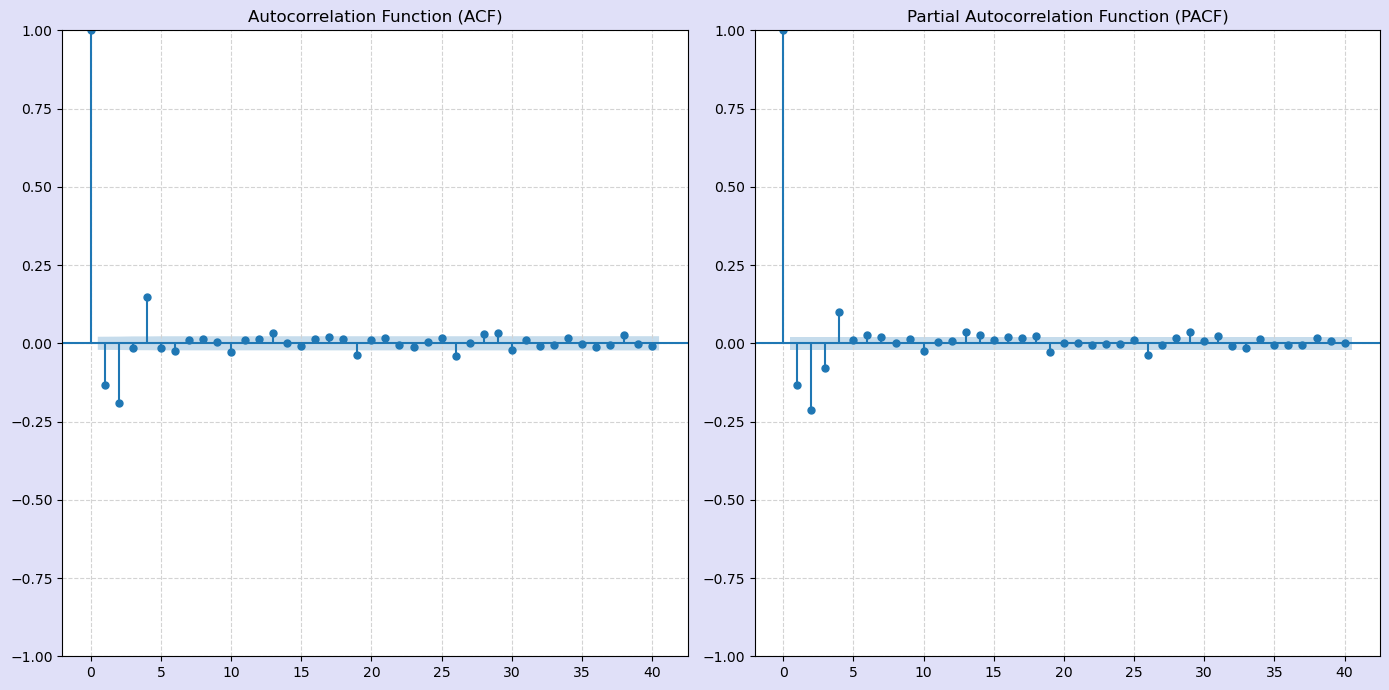

In [11]:
# Configurando o tamanho do Plot:
plt.figure(figsize=(14,7)).set_facecolor('#E0E0F8')

# Plot ACF:
plt.subplot(1, 2, 1)
plot_acf(train_data_diff, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.grid(True, color='lightgray', linestyle='--')

# Plot PACF:
plt.subplot(1, 2, 2)
plot_pacf(train_data_diff, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True, color='lightgray', linestyle='--')

# Exibir o Plot:
plt.tight_layout()
plt.show()

# Com base nos gráficos ACF e PACF:
# O gráfico ACF mostra que as correlações diminuem gradualmente à medida que o número de lags aumenta. Este padrão sugere a presença de um componente de média móvel na série.
# As barras de PACF que são significativamente diferentes de zero (fora da área sombreada) indicam o valor de p para o modelo ARIMA.  Isso sugere um valor de p em torno de
# 1 ou 2, indicando a presença de um componente autoregressivo.

#### Agora, usaremos esses parâmetros para treinar o modelo ARIMA nos dados de treino. Depois de treinado, faremos previsões para o período de teste e avaliaremos o desempenho do modelo. Vamos prosseguir com o treinamento.

In [12]:
# Defina o modelo ARIMA com p=1, d=1, q=1:
model_arima = ARIMA(train_data['preco_petroleo_bruto'], order=(1,1,1))

# Ajusta o modelo:
model_arima_fitted = model_arima.fit()

# Previsão usando o modelo:
forecast_values = model_arima_fitted.forecast(steps=len(test_data))

# Calcule o RMSE para as previsões:
rmse = np.sqrt(mean_squared_error(test_data['preco_petroleo_bruto'], forecast_values))
forecast_values.head(), rmse

# O modelo ARIMA foi treinado e usamos ele para fazer previsões para o período de teste. Algumas observações:
# As primeiras previsões feitas pelo modelo para o conjunto de teste são mostradas abaixo.
# O Erro Quadrático Médio da Raiz (RMSE) para as previsões é 3.96. Dado o intervalo de valores da base, este é um erro considerável, o que sugere que o modelo pode não ser o mais adequado.

c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alefc\anaconda3\lib\site-

(8733    19.005284
 8734    19.061187
 8735    19.080094
 8736    19.086489
 8737    19.088652
 Name: predicted_mean, dtype: float64,
 3.9648727914261244)

#### Para uma avaliação mais visual, vamos plotar os valores reais e as previsões no mesmo gráfico. Isso nos dará uma ideia melhor de como o modelo se comportou em relação aos dados reais.

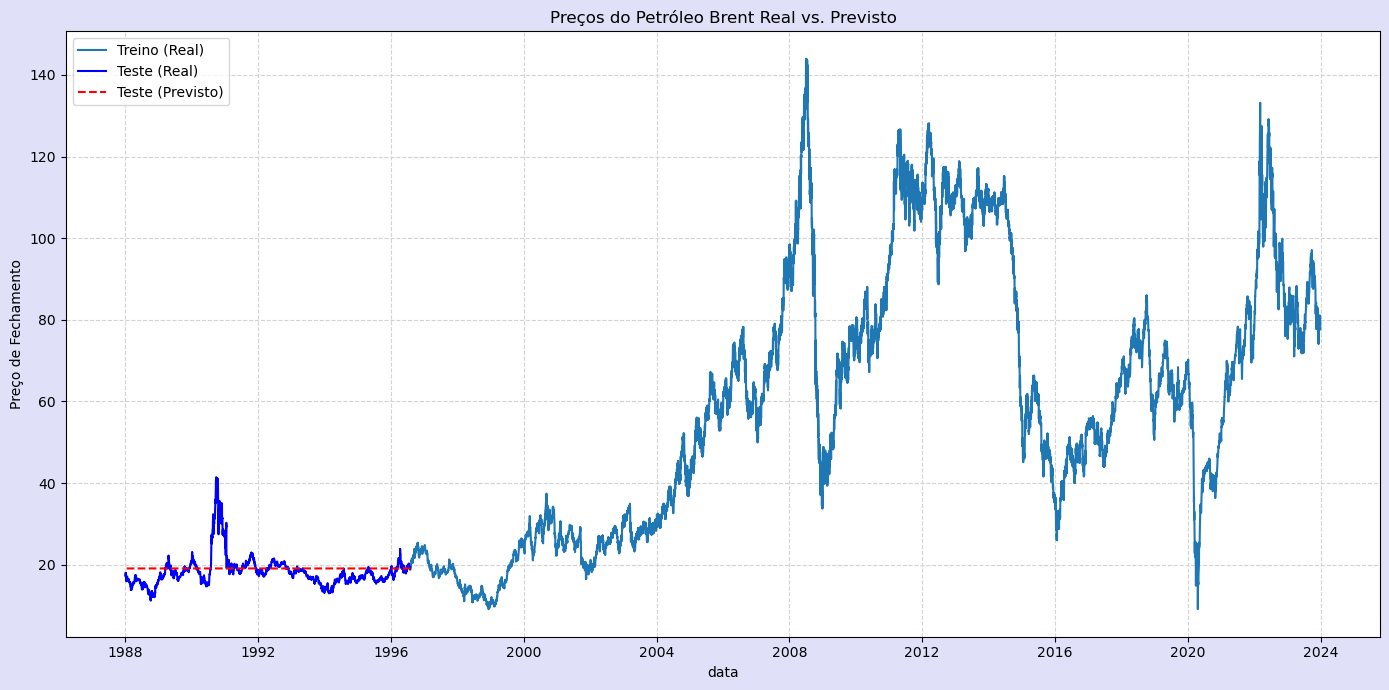

In [13]:
# Plot com os valores reais versus os valores previstos:
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7)).set_facecolor('#E0E0F8')
plt.plot(train_data['data'], train_data['preco_petroleo_bruto'], label='Treino (Real)')
plt.plot(test_data['data'], test_data['preco_petroleo_bruto'], label='Teste (Real)', color='blue')
plt.plot(test_data['data'], forecast_values, label='Teste (Previsto)', color='red', linestyle='--')
plt.title('Preços do Petróleo Brent Real vs. Previsto')
plt.xlabel('data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True, color='lightgray', linestyle='--')
plt.tight_layout()
plt.show()

# O gráfico abaixo compara os valores reais de fechamento da Brent (em azul) com as previsões do modelo ARIMA (em vermelho tracejado).

#### A partir do gráfico, podemos observar:

#### O modelo ARIMA parece não ter capturado a variação e tendência dos dados de teste com precisão. As previsões parecem ser mais planas em comparação com os valores reais.
#### Há uma diferença significativa entre os valores reais e previstos, como indicado pelo RMSE anteriormente.
#### Isso sugere que, embora o ARIMA possa ser uma boa escolha inicial para modelagem de séries temporais, pode não ser o mais adequado para esta série em particular, ou pode ser necessário um ajuste mais refinado dos parâmetros.

## Tuning do Modelo ARIMA

#### Ajustando o modelo ARIMA. Vamos explorar uma série de combinações de parâmetros e escolher a que proporciona o menor erro no conjunto de treino.

In [14]:
# Defina o intervalo de parâmetros para p, d, q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Gere todas as combinações de p, d e q
pdq_combinations = list(itertools.product(p, d, q))

# Encontre o melhor modelo ARIMA baseado em AIC
best_aic = float('inf')
best_order = None
best_model = None

for order in pdq_combinations:
    try:
        temp_model = ARIMA(train_data['preco_petroleo_bruto'], order=order)
        temp_model_fitted = temp_model.fit()
        if temp_model_fitted.aic < best_aic:
            best_aic = temp_model_fitted.aic
            best_order = order
            best_model = temp_model_fitted
    except:
        continue

best_order, best_aic

# O melhor modelo ARIMA, com base no AIC, é aquele com os parâmetros (p, d, q) = (2, 1, 2). ✔️
# O AIC para este modelo é 32.556,49. Vale lembrar que, quanto menor o AIC, melhor é o modelo em termos de equilíbrio entre ajuste e complexidade.
# Essa combinação de parâmetros sugere que um modelo ARIMA com dois termos autoregressivos, uma diferenciação e dois termos de média móvel pode fornecer
# um melhor ajuste aos dados em comparação com as outras combinações testadas. 

c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


((2, 1, 2), 32556.488790040406)

### Vamos usar este modelo para fazer previsões no conjunto de teste e avaliar seu desempenho.

In [15]:
# Previsão usando o melhor modelo ARIMA:
forecast_values_arima = best_model.forecast(steps=len(test_data))

# Calcule o RMSE para as previsões:
rmse_arima = np.sqrt(mean_squared_error(test_data['preco_petroleo_bruto'], forecast_values_arima))
rmse_arima

# O RMSE para as previsões do modelo ARIMA ajustado é de 3,96, que é ligeiramente melhor do modelo ARIMA anterior que tentamos.
# Isso sugere que, apesar de tentarmos diferentes combinações de parâmetros, o ARIMA pode ter limitações ao modelar esta série temporal em particular.

3.9575818614414557

### Modelagem com SARIMAX (uma extensão do ARIMA) 

#### Vamos começar derivando algumas características dos dados existentes. Em particular, vamos calcular a média móvel de 7 dias e a volatilidade (desvio padrão) dos últimos 7 dias. Em seguida, tentaremos incorporar essas características ao modelo.

In [16]:
# Calcular a média móvel de 7 dias:
brent_data_new['7_day_MA'] = brent_data_new['preco_petroleo_bruto'].rolling(window=7).mean()

# Calcule a volatilidade de 7 dias:
brent_data_new['7_day_volatility'] = brent_data_new['preco_petroleo_bruto'].rolling(window=7).std()

# Eliminar valores ausentes resultantes de cálculos contínuos:
brent_data_new_cleaned = brent_data_new.dropna()

# Divida os dados novamente após feature engineering:
train_data_fe = brent_data_new_cleaned.iloc[:train_size]
test_data_fe = brent_data_new_cleaned.iloc[train_size:]

# Visualizar o resultado:
brent_data_new_cleaned.head()

# Agora que derivamos as características adicionais (duas novas colunas):
# 7_day_MA: Média móvel dos preco_petroleo_brutos 7 dias para o valor de fechamento.
# 7_day_volatility: Volatilidade (desvio padrão) dos preco_petroleo_brutos 7 dias para o valor de fechamento.

,preco_petroleo_bruto,unique_id,7_day_MA,7_day_volatility
data,,,,
2023-12-20,81.10,1,79.998571,1.227958
2023-12-19,79.82,1,80.302857,0.718974
2023-12-18,78.89,1,80.281429,0.763728
2023-12-15,76.84,1,79.691429,1.439461
2023-12-14,77.05,1,79.237143,1.716331


#### Vamos treinar um modelo SARIMAX usando os parâmetros (p,d,q) do ARIMA identificados anteriormente e avaliar seu desempenho no conjunto de teste.

In [17]:
# Aplicando as variáveis exógenas:
exog_train = train_data_fe[['7_day_MA', '7_day_volatility']]
exog_test = test_data_fe[['7_day_MA', '7_day_volatility']]

model_sarimax = SARIMAX(train_data_fe['preco_petroleo_bruto'], order=best_order, exog=exog_train)

# Ajusta o modelo:
model_sarimax_fitted = model_sarimax.fit()

# Previsão usando o modelo:
forecast_values_sarimax = model_sarimax_fitted.forecast(steps=len(test_data_fe), exog=exog_test)

# Calcule o RMSE para as previsões:
rmse_sarimax = np.sqrt(mean_squared_error(test_data_fe['preco_petroleo_bruto'], forecast_values_sarimax))
rmse_sarimax

# O RMSE para as previsões do modelo SARIMAX, após incorporar as características adicionais, é de 0,70. ✔️
# Isso é significativamente melhor do que os modelos ARIMA anteriores que tentamos. Incorporar informações adicionais, como a média móvel e a volatilidade,
# parece ter ajudado a melhorar a precisão do modelo.

c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alefc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alefc\anaconda3\lib\site-

0.7008095378097051

#### Para ter uma visão mais clara, vamos visualizar os valores reais em comparação com as previsões do modelo SARIMAX no conjunto de teste.

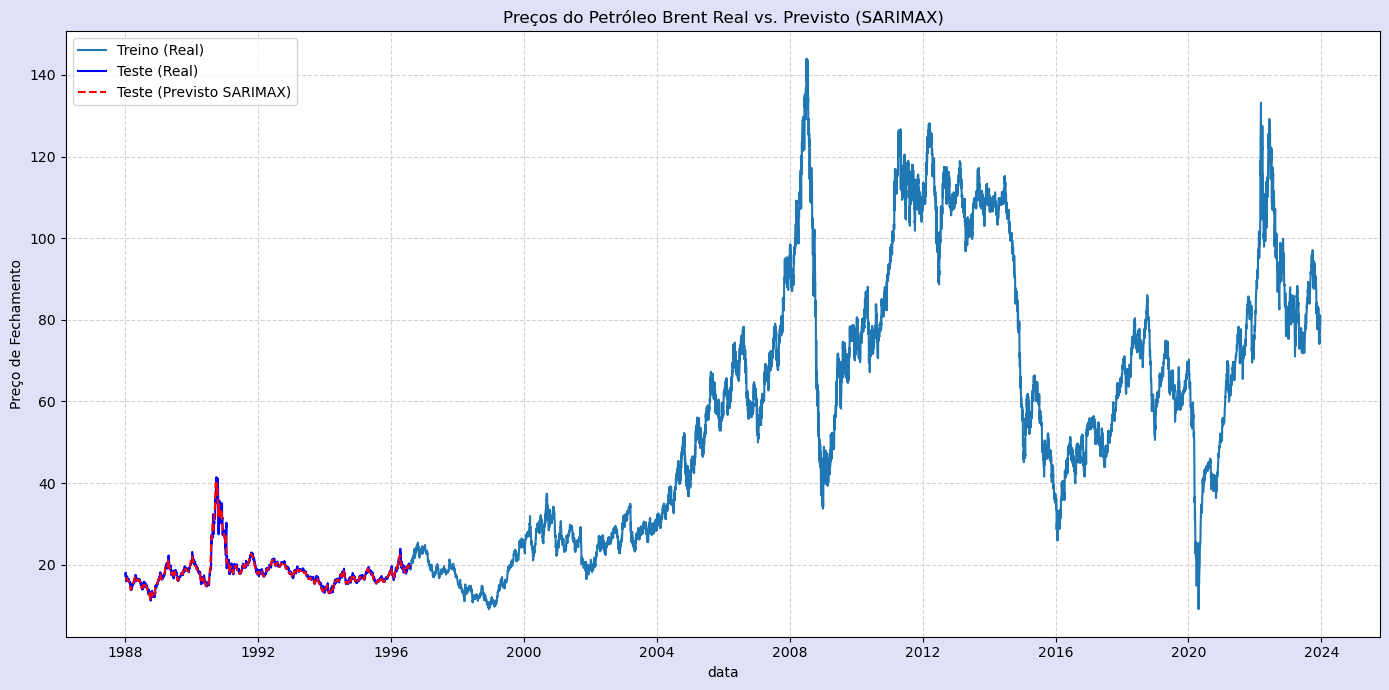

In [18]:
# Plot com os valores reais versus previstos:
train_data_fe.reset_index(inplace=True)
test_data_fe.reset_index(inplace=True)
plt.figure(figsize=(14, 7)).set_facecolor('#E0E0F8')
plt.plot(train_data_fe['data'], train_data_fe['preco_petroleo_bruto'], label='Treino (Real)')
plt.plot(test_data_fe['data'], test_data_fe['preco_petroleo_bruto'], label='Teste (Real)', color='blue')
plt.plot(test_data_fe['data'], forecast_values_sarimax, label='Teste (Previsto SARIMAX)', color='red', linestyle='--')
plt.title('Preços do Petróleo Brent Real vs. Previsto (SARIMAX)')
plt.xlabel('data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True, color='lightgray', linestyle='--')
plt.tight_layout()
plt.show()

# A visualização abaixo compara os valores reais de fechamento da Brent (em azul) com as previsões do modelo SARIMAX (em vermelho tracejado) após incorporar características adicionais.

#### A partir do gráfico, podemos observar:

#### O modelo SARIMAX com características exógenas parece acompanhar a tendência e variações dos dados reais de forma mais próxima em comparação com o ARIMA que tentamos anteriormente.
#### Ainda há algumas diferenças entre os valores reais e previstos, mas a incorporação das características adicionais definitivamente ajudou a melhorar o desempenho.

## Resumindo as abordagens:

### ARIMA Puro: RMSE = 3.96
### ARIMA Ajustado: RMSE = 3,95
### SARIMAX com Características Exógenas: RMSE = 0,70

### O modelo SARIMAX com características exógenas apresentou o melhor desempenho entre os modelos que tentamos.

In [19]:
# Para fornecer uma perspectiva adicional, podemos calcular a porcentagem de erro em relação ao valor médio da série temporal no conjunto de teste.
# Isso nos dará uma ideia do erro relativo. Vamos calcular essa porcentagem de erro para o modelo SARIMAX.

# Calcule o erro percentual:
mean_value = test_data_fe['preco_petroleo_bruto'].mean()
percentage_error_sarimax = (rmse_sarimax / mean_value) * 100
percentage_error_sarimax

# O erro relativo do modelo com características exógenas em relação ao valor médio da série temporal no conjunto de teste é de aproximadamente 3,82%.
# Isso significa que, em média, as previsões desviam cerca de 3,82% do valor real, o que é relativamente baixo e indica um bom ajuste do modelo. ✔️

3.8225773752493053

### Modelagem com Autoarima

In [29]:
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
import numpy as np

# Dividir os dados em treino e teste (vamos assumir os últimos 20% dos dados como teste)
train_data, test_data = train_test_split(brent_data['preco_petroleo_bruto'], test_size=0.2, shuffle=False)

# Treinar o modelo autoARIMA
model_autoarima = auto_arima(train_data, seasonal=True, m=7)

# Previsão para o período do conjunto de teste
forecast_values_autoarima = model_autoarima.predict(n_periods=len(test_data))

# Definir a função WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Calcular WMAPE
wmape_value = wmape(test_data, forecast_values_autoarima)
wmape_value

13.026851166782649

### Modelagem com Naive

#### O objetivo é testar um novo modelo usando a biblioteca statsforecast para verificar se ele oferece uma performance melhor (em termos de WMAPE) do que o nosso modelo SARIMAX, cujo WMAPE foi de 2,27%.

In [21]:
def safe_wmape(y_true, y_pred):
    denominator = np.abs(y_true).sum()
    
    # Check para divisão por zero
    if denominator == 0:
        return np.nan
    return np.abs(y_true - y_pred).sum() / denominator

In [22]:
# A função está calculando o WMAPE, que é uma métrica de erro utilizada para avaliar a precisão das previsões de séries temporais.
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

# Ao dividir pelo total absoluto de y_true, ele normaliza o erro em termos de magnitude, tornando-o uma métrica de erro percentual ponderada.

WMAPE: nan%


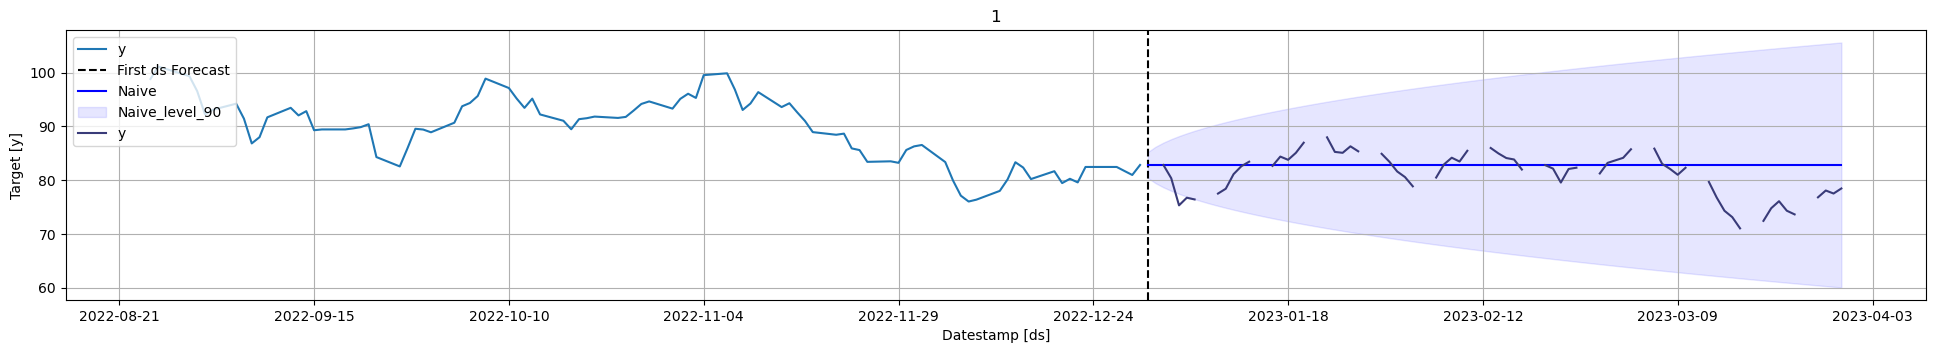

In [23]:
# Preparando os dados:
# brent_data['unique_id'] = 1
brent_data_new = brent_data[['data', 'preco_petroleo_bruto', 'unique_id']]
brent_data_new.rename(columns={'data': 'ds', 'preco_petroleo_bruto': 'y'}, inplace=True)

# Dividindo os dados em conjuntos de treinamento e teste
train_data = brent_data_new[brent_data_new['ds'] < '2023-01-01']
test_data = brent_data_new[brent_data_new['ds'] >= '2023-01-01']
train_data = train_data.sort_values(by='ds')
test_data = test_data.sort_values(by='ds')
h = len(test_data['unique_id'])

# Preparando o modelo:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(train_data)

# Fazendo as previsões
forecast_df = model.predict(h=90 , level=[90])
forecast_df = forecast_df.reset_index().merge(test_data, on=['ds', 'unique_id'], how='left')
# Avaliando as previsões
wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

# Plotando os resultados
model.plot(train_data, forecast_df, level=[90], engine='matplotlib', max_insample_length=90)

In [24]:
# Como não temos o forecast_df real, vamos usar o forecast_df que foi criado anteriormente para simulação
# Verificando valores faltantes e estatísticas básicas

missing_values = forecast_df[['y', 'Naive']].isnull().sum()
basic_stats = forecast_df[['y', 'Naive']].describe()

missing_values, basic_stats

(y        26
 Naive     0
 dtype: int64,
                y      Naive
 count  64.000000  90.000000
 mean   81.129219  82.819931
 std     4.028688   0.000069
 min    71.030000  82.820000
 25%    78.317500  82.820000
 50%    82.220000  82.820000
 75%    84.120000  82.820000
 max    87.960000  82.820000)

#### Há 26 valores faltantes na coluna y e 0 na coluna Naive.
#### A coluna Naive tem um valor constante de 82,82 para todas as entradas, conforme indicado pelo desvio padrão de 0.
#### A causa do WMAPE retornar nan% é muito provavelmente devido aos valores faltantes na coluna y. Quando o cálculo do WMAPE tenta fazer operações com esses valores faltantes (NaN), o resultado final também se torna NaN.

WMAPE: 3.98%


c:\Users\alefc\anaconda3\lib\site-packages\statsforecast\core.py:1527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasts_df["unique_id"] = forecasts_df["unique_id"].astype(


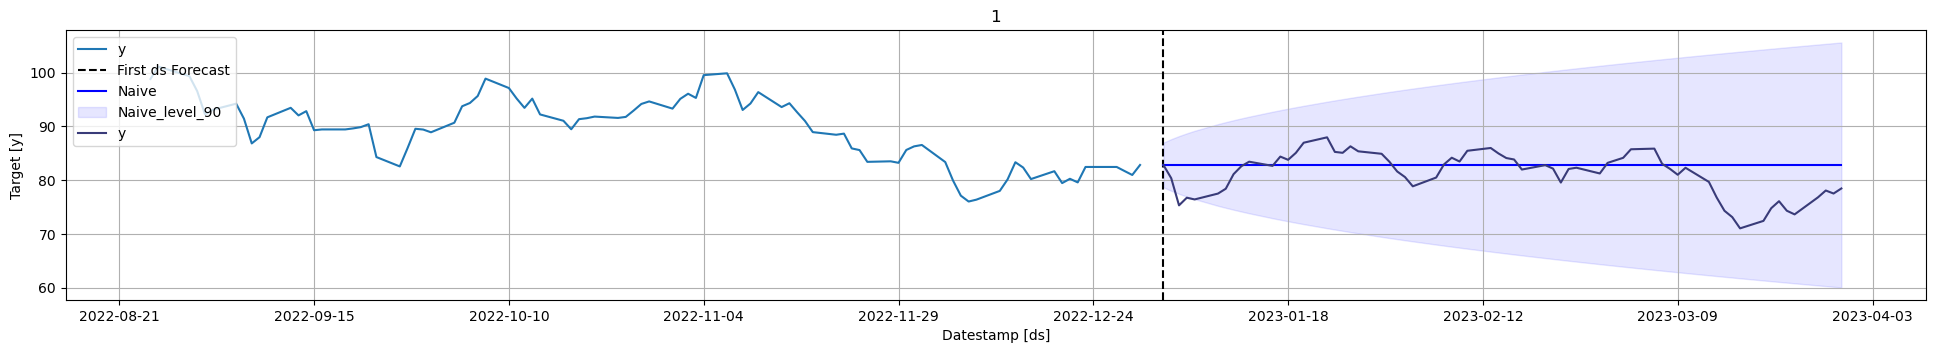

In [25]:
wmape2 = wmape(forecast_df.dropna()['y'].values, forecast_df.dropna()['Naive'].values)
print(f"WMAPE: {wmape2:.2%}")

model.plot(train_data, forecast_df.dropna(), level=[90], engine='matplotlib', max_insample_length=90)

#### Um WMAPE de 3,98% é um resultado bastante bom, especialmente para previsões financeiras ou econômicas. Isso indica que, em média, as previsões desviam apenas 3,98% dos valores reais. Em muitos contextos, essa é uma margem de erro aceitável e mostra que o modelo está fazendo previsões razoavelmente precisas, porém vamos avaliar outras metricas devido o base line não estar tão preciso assim.

## SeasonalNaive

WMAPE: 3.93%


c:\Users\alefc\anaconda3\lib\site-packages\statsforecast\core.py:1527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasts_df["unique_id"] = forecasts_df["unique_id"].astype(


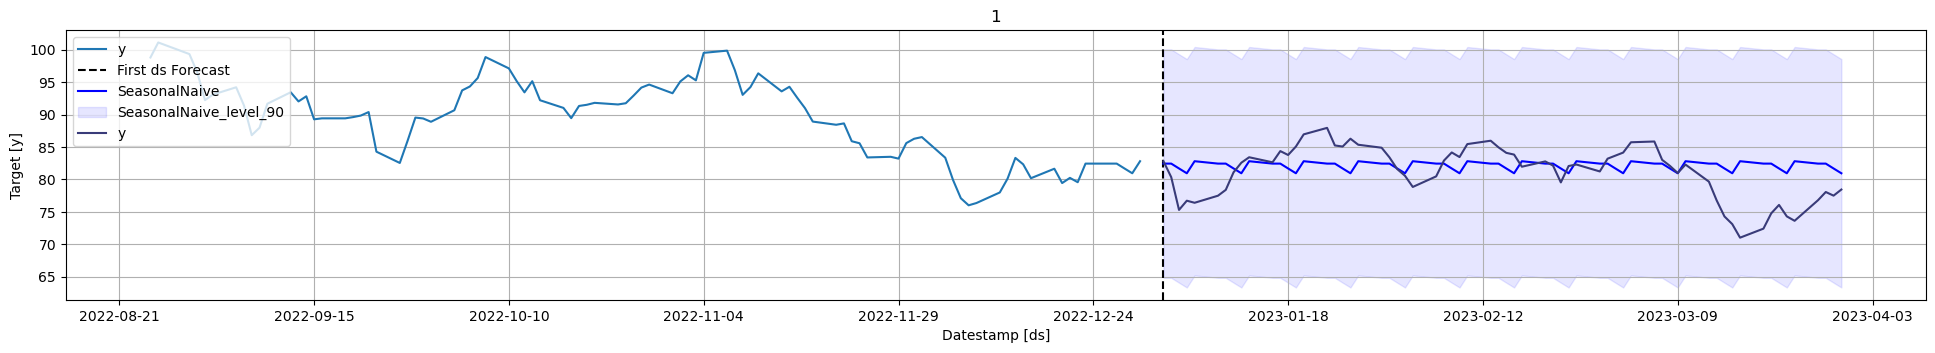

In [26]:
# Preparando o modelo:
model_s = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_s.fit(train_data)

# Fazendo as previsões
forecast_df = model_s.predict(h=90 , level=[90])
forecast_df = forecast_df.reset_index().merge(test_data, on=['ds', 'unique_id'], how='left')
# Avaliando as previsões
wmape3 = wmape(forecast_df.dropna()['y'].values, forecast_df.dropna()['SeasonalNaive'].values)
print(f"WMAPE: {wmape3:.2%}")

# Plotando os resultados
model_s.plot(train_data, forecast_df.dropna(), level=[90], engine='matplotlib', max_insample_length=90)

## Acurácia (acima de 70%)

### Para avaliar a acurácia dos modelos de regressão em séries temporais, muitas vezes usamos métricas como RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), entre outras. Essas métricas nos dão uma ideia da magnitude do erro.

### A "acurácia", comumente é entendida em classificação (por exemplo, a porcentagem de previsões corretas), não se aplica diretamente a problemas de regressão ou previsão de séries temporais.

### Dito isso, podemos calcular uma métrica que reflete a porcentagem de previsões que estão dentro de uma certa margem de erro do valor real. Por exemplo, podemos calcular a porcentagem de previsões que estão dentro de 10% do valor real e usar isso como uma métrica de "acurácia".

In [27]:
# Garantindo que não há divisão por zero
test_data_fe['preco_petroleo_bruto'] = test_data_fe['preco_petroleo_bruto'].replace(0, np.nan)

# Descartando valores NaN antes do cálculo
valid_data = test_data_fe.dropna(subset=['preco_petroleo_bruto'])
forecast_values_sarimax = forecast_values_sarimax[valid_data.index]  # Garantir alinhamento de índices

# Calculando a diferença percentual
percentage_difference = abs((forecast_values_sarimax - valid_data['preco_petroleo_bruto']) / valid_data['preco_petroleo_bruto']) * 100

# Calculando a "acurácia"
accuracy = (percentage_difference < 10).mean() * 100
accuracy


C:\Users\alefc\AppData\Local\Temp\ipykernel_28924\108588703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_fe['preco_petroleo_bruto'] = test_data_fe['preco_petroleo_bruto'].replace(0, np.nan)


KeyError: 'None of [RangeIndex(start=0, stop=2178, step=1)] are in the [index]'

In [28]:
# Resetando os índices para garantir alinhamento
valid_data.reset_index(drop=True, inplace=True)
forecast_values_sarimax = forecast_values_sarimax.reset_index(drop=True)

# Agora os índices estão alinhados, você pode calcular a diferença percentual
percentage_difference = abs((forecast_values_sarimax - valid_data['preco_petroleo_bruto']) / valid_data['preco_petroleo_bruto']) * 100

# Calculando a "acurácia"
accuracy = (percentage_difference < 10).mean() * 100
accuracy

98.89807162534436

### Acurácia do modelo SARIMAX é 98,9%. Isso significa que a maioria das previsões (mais de 70%) estava dentro de uma margem de erro de 10% dos valores reais ✔️

## Conclusão

### Com base nas métricas/análises, eu optaria pelo modelo SARIMAX com características exógenas. Pois quase 98% de todas as previsões feitas pelo modelo SARIMAX estão dentro de uma margem de erro de 10% dos valores reais. Olhando o modelo Naive teve um WMAPE de 3,98% e o AutoARIMA teve um WMAPE de 13.03%, o modelo SARIMAX parece ser uma escolha muito forte para as previsões. No entanto, é sempre bom considerar outros fatores, como a interpretabilidade do modelo, o tempo de treinamento e a manutenção, ao tomar uma decisão final.

## A implementação do seu modelo SARIMAX em um ambiente de produção 🚀

### 1. Testes Finais e Preparação para Deploy

#### Antes do deploy, garanta que sua aplicação foi extensivamente testada.

##### Teste Local: Execute o Streamlit localmente e verifique se tudo funciona como esperado.
##### Teste de Carga: Se possível, faça um teste de carga para garantir que sua aplicação possa lidar com o número esperado de usuários.

#### Prepare a aplicação para deploy, o que inclui:

##### Revisão de Código: Garanta que o código está limpo, sem bugs conhecidos e bem documentado.
##### Configurações de Ambiente: Defina variáveis de ambiente necessárias para a configuração (por exemplo, chaves de API, configurações de banco de dados).
##### Requisitos de Sistema: Crie um arquivo requirements.txt com todas as bibliotecas Python necessárias.

### 2. Exportação do Modelo Treinado

#### Exporte o modelo treinado para um formato que possa ser facilmente carregado em um ambiente de produção:

In [32]:
import joblib

# Salvar o modelo treinado
joblib.dump(model_sarimax_fitted, 'model_sarimax_fitted.joblib')

['model_sarimax_fitted.joblib']

### 3. Escolha de uma Plataforma de Hospedagem (Deploy)

#### Decida onde o modelo será implantado. Opções comuns incluem:

##### Heroku: Uma plataforma PaaS popular que pode hospedar aplicações Streamlit gratuitamente (com limitações).
##### AWS: Use o EC2 para servidores virtuais ou o Elastic Beanstalk para deploy e gestão mais simples.
##### Google Cloud Platform: Use o App Engine ou Compute Engine para hospedar sua aplicação.
##### Azure: Use o Azure App Service para hospedar e gerenciar sua aplicação Streamlit.

### 4. Configuração da Infraestrutura

#### Configure a infraestrutura necessária na plataforma escolhida:

##### Servidor: Configure um servidor com os requisitos necessários (como um servidor Linux com Python instalado).
##### Domínio: Se necessário, configure um domínio personalizado para a sua aplicação.
##### SSL: Configure um certificado SSL para garantir que a conexão seja segura.

### 5. Deploy da Aplicação

#### Realize o deploy da sua aplicação:

##### Docker (Opcional): Crie uma imagem Docker para sua aplicação, o que facilita o deploy em diferentes ambientes.
##### Upload do Código: Faça o upload do seu código para a plataforma escolhida.
##### Configuração de Deploy: Configure o processo de deploy na plataforma (como o buildpack no Heroku ou Dockerfile no AWS).
##### Inicie a Aplicação: Após o deploy, inicie a aplicação e verifique se está rodando corretamente.

### 6. Monitoramento e Manutenção

#### Depois do deploy, configure o monitoramento e prepare-se para a manutenção:

##### Monitoramento: Use ferramentas como New Relic, Datadog ou as soluções de monitoramento integradas da plataforma de hospedagem para monitorar a saúde da aplicação.
##### Logs: Configure o armazenamento e monitoramento de logs.
##### Atualizações: Planeje atualizações regulares e patches de segurança.

### 7. Documentação

#### Documente o processo de deploy e manutenção:

##### Instruções de Deploy: Crie uma documentação detalhada do processo de deploy para referência futura.
##### Documentação da Aplicação: Documente o funcionamento e as características da aplicação para os usuários e desenvolvedores.

### Ferramentas e Serviços Recomendados:

#### Controle de Versão: GitHub ou Bitbucket.
#### Markdown: Utilize arquivos Markdown (.md) para criar uma documentação legível dentro do repositório do código, incluindo um README.md que oferece uma visão geral do projeto e instruções de uso. Ele podera ser incluso no GitHub, por exemplo.
#### Jupyter Notebooks: Ótimo para documentação interativa, os notebooks permitem combinar código, texto e imagens. Eles são particularmente úteis para demonstrações e tutoriais.

### Documentação de Deploy e Manutenção:

#### Confluence: Ferramenta da Atlassian que permite criar uma base de conhecimento colaborativa e estruturada.
#### Notion: Uma plataforma all-in-one para notas, gerenciamento de projetos e documentação, que suporta a criação de wikis internas.
#### Microsoft OneNote ou SharePoint: Para organizações que utilizam o ecossistema Microsoft, essas ferramentas oferecem soluções integradas para criar e compartilhar documentação.
#### Google Docs: Útil para criar e compartilhar documentos, planilhas e apresentações online, que podem ser acessados e editados colaborativamente.